# pytorch CNN 手寫辨識


In [28]:
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms, utils


In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)


In [30]:
train_data = datasets.MNIST(
    root="./data/", transform=transform, train=True, download=True
)

test_data = datasets.MNIST(root="./data/", transform=transform, train=False)

In [31]:
len(test_data)

10000

In [32]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=True, num_workers=2
)

In [33]:
print(len(train_loader))
print(len(test_loader))

938
157


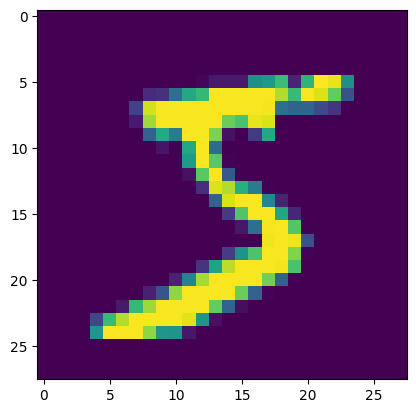

In [34]:
# data_iter = iter(train_loader)
# print(next(data_iter))
oneimg, label = train_data[0]
oneimg = oneimg.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28, 28)
plt.imshow(oneimg)
plt.show()
# 從二為數組中生成一張圖片


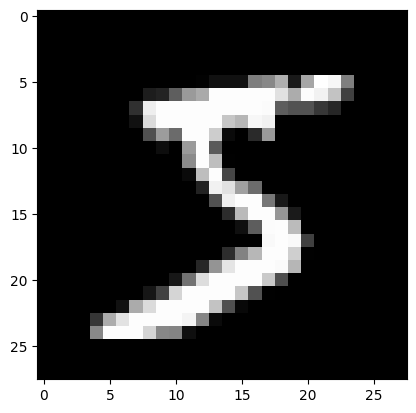

In [35]:
oneimg, label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()
# 從三維中生成一張圖片


tensor(5) tensor(1) tensor(8) tensor(2) tensor(0) tensor(3) tensor(3) tensor(4) 
tensor(7) tensor(3) tensor(9) tensor(8) tensor(5) tensor(9) tensor(6) tensor(0) 
tensor(6) tensor(5) tensor(3) tensor(1) tensor(4) tensor(3) tensor(3) tensor(8) 
tensor(3) tensor(2) tensor(2) tensor(6) tensor(7) tensor(6) tensor(1) tensor(1) 
tensor(8) tensor(8) tensor(5) tensor(4) tensor(9) tensor(7) tensor(6) tensor(6) 
tensor(4) tensor(9) tensor(1) tensor(2) tensor(6) tensor(9) tensor(1) tensor(1) 
tensor(9) tensor(5) tensor(2) tensor(1) tensor(1) tensor(8) tensor(7) tensor(9) 
tensor(0) tensor(4) tensor(9) tensor(9) tensor(6) tensor(2) tensor(9) tensor(4) 


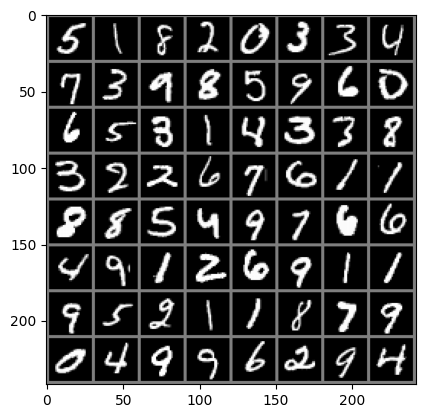

In [36]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 轉置函數(x=0,y=1,z=2),新的x是原来的y軸大小，新的y是原来的z軸大小，新的z是原来的x大小
# 相當於把x=1這個一道最後面去。
img = img.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i % 8 == 0:
        print(end="\n")
plt.imshow(img)
plt.show()


In [37]:
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)  # 兩個池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    #         self.dp = nn.Dropout(p=0.5)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)  # 將數據平整為一維的
        x = F.relu(self.fc1(x))
        #         x = self.fc3(x)
        #         self.dp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x


net = CNN()

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)


In [24]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  # 0是下標起始位置默認為0
        # data 的格式[[inputs, labels]]
        #         inputs,labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # 初始為0，清除上個batch的梯度訊息
        optimizer.zero_grad()

        # 前向+後向+優化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每一百個batch輸出，平均的loss
        running_loss += loss.item()
        if i % 100 == 99:
            print("[%d,%5d] loss :%.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        train_loss.append(loss.item())

        # 訓練曲線的繪製 一個batch中的準確率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)  # labels 的長度
        correct = (predicted == labels).sum().item()  # 預測正確的數字
        train_accs.append(100 * correct / total)

print("Finished Training")


[1,  100] loss :1.452
[1,  200] loss :0.383
[1,  300] loss :0.313
[1,  400] loss :0.264
[1,  500] loss :0.272
[1,  600] loss :0.243
[1,  700] loss :0.230
[1,  800] loss :0.210
[1,  900] loss :0.236
[2,  100] loss :0.197
[2,  200] loss :0.192
[2,  300] loss :0.187
[2,  400] loss :0.188
[2,  500] loss :0.188
[2,  600] loss :0.169
[2,  700] loss :0.180
[2,  800] loss :0.174
[2,  900] loss :0.194
[3,  100] loss :0.147
[3,  200] loss :0.150
[3,  300] loss :0.155
[3,  400] loss :0.185
[3,  500] loss :0.170
[3,  600] loss :0.167
[3,  700] loss :0.187
[3,  800] loss :0.171
[3,  900] loss :0.157
Finished Training


In [25]:
PATH = "./mnist_net.pth"
torch.save(net.state_dict(), PATH)


In [26]:
def draw_train_process(title, iters, costs, accs, label_cost, lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs, color="red", label=label_cost)
    plt.plot(iters, accs, color="green", label=lable_acc)
    plt.legend()
    plt.grid()
    plt.show()


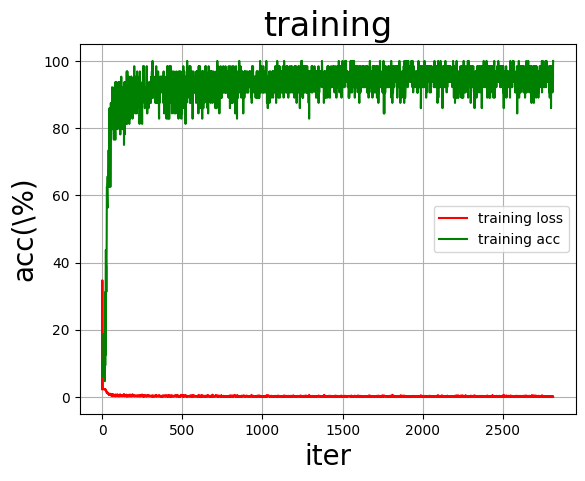

In [27]:
train_iters = range(len(train_accs))
draw_train_process(
    "training", train_iters, train_loss, train_accs, "training loss", "training acc"
)